In [0]:
import struct
from struct import unpack
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = {}'.format(device))

In [0]:
# Helper from: https://github.com/googlecreativelab/quickdraw-dataset/blob/master/examples/binary_file_parser.py
def unpack_drawing(file_handle):
    # Skip key_id: 8, countrycode: 2, recognized: 1, timestamp: 4 = 15
    file_handle.read(15)
    n_strokes, = unpack('H', file_handle.read(2))
    idx = 0

    N = 0
    strokes = []
    for i in range(n_strokes):
      n_points, = unpack('H', file_handle.read(2))
      N += n_points
      fmt = str(n_points) + 'B'
      x = unpack(fmt, file_handle.read(n_points))
      y = unpack(fmt, file_handle.read(n_points))
      strokes.append((x, y))

    image = np.zeros((N, 3), dtype=np.float32)


    # Return a tensor of size number of stroke x 3 like here: https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/recurrent_quickdraw.md#optional-converting-the-data
    for i, (x, y) in enumerate(strokes):
        n_points = len(x)
        image[idx:idx+n_points, 0] = np.asarray(x)
        image[idx:idx+n_points, 1] = np.asarray(y)
        idx += n_points
        # Mark stroke end with a 1
        image[idx -1, 2] = 1


    # Preprocessing.
    # 1. Size normalization.
    lower = np.min(image[:, 0:2], axis=0)
    upper = np.max(image[:, 0:2], axis=0)
    scale = upper - lower
    scale[scale == 0] = 1
    image[:, 0:2] = (image[:, 0:2] - lower) / scale
    # 2. Compute deltas.
    image[1:, 0:2] -= image[0:-1, 0:2]
    image = image[1:, :]

    return torch.FloatTensor(image)


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

In [0]:
!wget 'https://raw.githubusercontent.com/cs-deep-quickdraw/notebooks/master/100_classes.txt'
!mkdir data

In [0]:
import urllib.request

f = open("100_classes.txt","r")
# And for reading use
classes = [cls.strip() for cls in f.readlines()]
f.close()

def download(classes):
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
  for i, c in enumerate(classes):
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.bin'
    print((1+i)/len(classes), c, path)
    urllib.request.urlretrieve(path, 'data/'+c+'.bin')

In [0]:
download(classes)

0.01 drums https://storage.googleapis.com/quickdraw_dataset/full/binary/drums.bin
0.02 sun https://storage.googleapis.com/quickdraw_dataset/full/binary/sun.bin
0.03 laptop https://storage.googleapis.com/quickdraw_dataset/full/binary/laptop.bin
0.04 anvil https://storage.googleapis.com/quickdraw_dataset/full/binary/anvil.bin
0.05 baseball_bat https://storage.googleapis.com/quickdraw_dataset/full/binary/baseball%20bat.bin
0.06 ladder https://storage.googleapis.com/quickdraw_dataset/full/binary/ladder.bin
0.07 eyeglasses https://storage.googleapis.com/quickdraw_dataset/full/binary/eyeglasses.bin
0.08 grapes https://storage.googleapis.com/quickdraw_dataset/full/binary/grapes.bin
0.09 book https://storage.googleapis.com/quickdraw_dataset/full/binary/book.bin
0.1 dumbbell https://storage.googleapis.com/quickdraw_dataset/full/binary/dumbbell.bin
0.11 traffic_light https://storage.googleapis.com/quickdraw_dataset/full/binary/traffic%20light.bin
0.12 wristwatch https://storage.googleapis.com/qu

In [0]:
!ls data

airplane.bin	  circle.bin	    key.bin	      shorts.bin
alarm_clock.bin   clock.bin	    knife.bin	      shovel.bin
anvil.bin	  cloud.bin	    ladder.bin	      smiley_face.bin
apple.bin	  coffee_cup.bin    laptop.bin	      snake.bin
axe.bin		  cookie.bin	    light_bulb.bin    sock.bin
baseball_bat.bin  cup.bin	    lightning.bin     spider.bin
baseball.bin	  diving_board.bin  line.bin	      spoon.bin
basketball.bin	  donut.bin	    lollipop.bin      square.bin
beard.bin	  door.bin	    microphone.bin    star.bin
bed.bin		  drums.bin	    moon.bin	      stop_sign.bin
bench.bin	  dumbbell.bin	    mountain.bin      suitcase.bin
bicycle.bin	  envelope.bin	    moustache.bin     sun.bin
bird.bin	  eye.bin	    mushroom.bin      sword.bin
book.bin	  eyeglasses.bin    pants.bin	      syringe.bin
bread.bin	  face.bin	    paper_clip.bin    table.bin
bridge.bin	  fan.bin	    pencil.bin	      tennis_racquet.bin
broom.bin	  flower.bin	    pillow.bin	      tent.bin
butterfly.bin	  frying_pan.bin    pizza.bi

In [0]:
i_drawings = unpack_drawings("data/anvil.bin")

In [0]:
from pprint import pprint
pprint(next(i_drawings)[:2])
pprint(next(i_drawings)[:2])

tensor([[ 0.2235, -0.0404,  0.0000],
        [ 0.3176, -0.0101,  0.0000]])
tensor([[-0.0118,  0.3372,  0.0000],
        [ 0.0984, -0.0116,  0.0000]])


In [0]:
class StrokeClassifier(nn.Module):

  def __init__(self, hidden_dim, n_layers, n_classes):
    super(StrokeClassifier, self).__init__()
    self.hidden_dim = hidden_dim

    # The LSTM takes 3 things as input (x, y, isLastPoint) and outputs hidden states with dimensionality hidden_dim
    self.lstm = nn.LSTM(3, hidden_dim, n_layers, batch_first=True)

    # The linear layer maps the LSTM output to a linear space
    self.linear = nn.Linear(hidden_dim, n_classes)

  def forward(self, strokes):
    # initial states
    h0 = torch.zeros(1, strokes.size(0), self.hidden_dim).to(device)
    c0 = torch.zeros(1, strokes.size(0), self.hidden_dim).to(device)

    out, _ = self.lstm(strokes)
    # Keep last layer of the NN
    out = out[:,-1,:]
    out = self.linear(out)
    return out


In [0]:
from torch.utils.data import Dataset

class DrawDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        assert len(self.X) == len(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return [torch.Tensor(self.X[idx]).type('torch.FloatTensor'), self.Y[idx]]

In [0]:
# Config:
batch_size = 512
learning_rate = 0.01

hidden_size = 64
n_layers = 2
train_classes = classes[:]

N_train = 12000
N_val = 2000
N_test = 2000
N_test_reserved = 20000
max_padding = 100
n_epochs = 20

In [0]:
from itertools import islice
from torch.nn.utils.rnn import pad_sequence

def extract_dataset(samples_train, samples_val, samples_test, test_reserved, classes, max_padding=100):
  X_train = []
  X_val = []
  X_test = []
  y_train = []
  y_val = []
  y_test = []

  for c, cls in enumerate(classes):
    drawings = unpack_drawings('data/' + cls + '.bin')

    # TODO: better way of doing this
    for _ in range(samples_train):
      X_train.append(next(drawings))
      y_train.append(c)

    # TODO: itertools
    for _ in range(max(0, test_reserved - samples_train)):
      next(drawings)

    for _ in range(samples_val):
      X_val.append(next(drawings))
      y_val.append(c)

    for _ in range(samples_test):
      X_test.append(next(drawings))
      y_test.append(c)
  
    if c % 10 == 0:
      print(f"done extracting class: {cls}: {1 + c} / {len(classes)}")
    

  # XXX: instead of padding like that we could have a moving window:
  # Example if we want 100 sequences and we have an image with 200 we can use the windows:
  # 0-100, 10-110, ... 100-200 for instance, this would add data
  X_train = pad_sequence(X_train, batch_first=True)[:, :max_padding, :]
  X_val = pad_sequence(X_val, batch_first=True)[:, :max_padding, :]
  X_test = pad_sequence(X_test, batch_first=True)[:, :max_padding, :]
  print("training shape", X_train.shape)
  print("validation shape", X_val.shape)
  print("testing shape", X_test.shape)
  print("classes", len(classes))

  return DrawDataset(X_train, y_train), DrawDataset(X_val, y_val), DrawDataset(X_test, y_test)

In [0]:
def evaluate_model(model, loader):
  with torch.no_grad():
    correct = 0
    total = 0
    
    for i, (img, label) in enumerate(loader):
      img = img.to(device)
      label = label.to(device)

      out = model(img)

      _, pred = torch.max(out.data, 1)

      total += label.size(0)
      correct += (pred == label).sum().item()

    return 100. * correct / total

In [0]:
import matplotlib.pyplot as plt

def plot_training(losses, accs, n_epochs):
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('training loss', color=color)
  ax1.plot(losses, color=color)
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.set_ylim([0, 5])

  ax1.set_xlim([0, n_epochs])
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('validation accuracy', color=color)  # we already handled the x-label with ax1
  ax2.plot(accs, color=color)
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim([0, 100])

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()

In [0]:
import copy

def train_model(model, opt, loss_fn, loader, v_loader, n_epochs):

  best_acc, best_model = 0, None
  losses, accs = [], []
  for epoch in range(n_epochs):
    epoch_losses = []
    for i, (img, lab) in enumerate(loader):
      img = img.to(device)
      lab = torch.LongTensor(lab).to(device)

      out = model(img)

      loss = loss_fn(out, lab)

      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_losses.append(loss.item())

    val_acc = evaluate_model(model, v_loader)
    mean_loss = np.mean(epoch_losses)

    losses.append(mean_loss)
    accs.append(val_acc)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model = copy.deepcopy(model.state_dict())

    print(f"Epoch: {epoch+1}/{n_epochs}, loss: {mean_loss}, validation accuracy: {val_acc}%")

  print(f"Training ended after {n_epochs} ! Best validation accuracy: {best_acc}%")
  try:
    plot_training(losses, accs, n_epochs)
  except:
    print("error occurred when plotting losses and accuracy training data")
  return best_model, losses, accs

In [0]:
from torch.nn.utils.rnn import pad_sequence

# TODO: really take the last 2k images for testing
train_dataset, val_dataset, test_dataset = extract_dataset(N_train, N_val, N_test, N_test_reserved, train_classes, max_padding=max_padding)

done extracting class: drums: 1 / 100
done extracting class: traffic_light: 11 / 100
done extracting class: face: 21 / 100
done extracting class: clock: 31 / 100
done extracting class: diving_board: 41 / 100
done extracting class: hat: 51 / 100
done extracting class: basketball: 61 / 100
done extracting class: pencil: 71 / 100
done extracting class: donut: 81 / 100
done extracting class: ice_cream: 91 / 100
training shape torch.Size([1200000, 100, 3])
validation shape torch.Size([200000, 100, 3])
testing shape torch.Size([200000, 100, 3])
classes 100


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [0]:
import torch.optim as optim

model = StrokeClassifier(hidden_size, n_layers, len(train_classes)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  del sys.path[0]


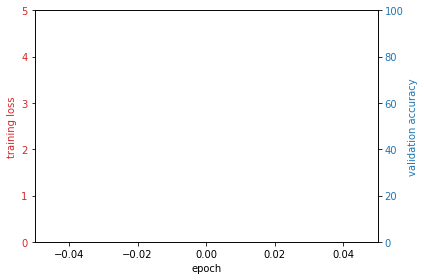

Epoch: 1/20, loss: 4.606408783803621, validation accuracy: 1.0%
Epoch: 2/20, loss: 4.606318667683585, validation accuracy: 1.0%
Epoch: 3/20, loss: 4.6063090513997516, validation accuracy: 1.0%
Epoch: 4/20, loss: 4.385479435273812, validation accuracy: 17.824%
Epoch: 5/20, loss: 2.213939575408506, validation accuracy: 58.963%


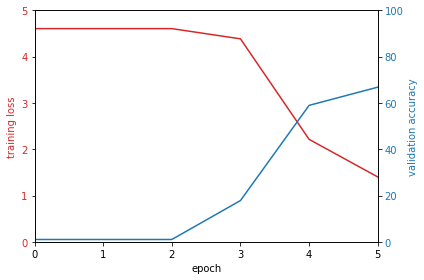

Epoch: 6/20, loss: 1.4017185361820683, validation accuracy: 66.819%
Epoch: 7/20, loss: 1.21909671564151, validation accuracy: 57.5815%
Epoch: 8/20, loss: 3.3761518669820076, validation accuracy: 1.216%
Epoch: 9/20, loss: 4.5962782852071955, validation accuracy: 1.8105%
Epoch: 10/20, loss: 4.491882045724693, validation accuracy: 3.9325%


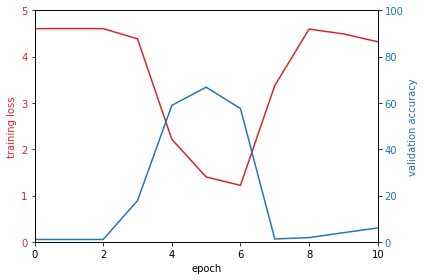

Epoch: 11/20, loss: 4.322484948732747, validation accuracy: 5.9895%
Epoch: 12/20, loss: 4.341253318375695, validation accuracy: 4.131%
Epoch: 13/20, loss: 4.108245983668969, validation accuracy: 10.3655%
Epoch: 14/20, loss: 3.644478832597212, validation accuracy: 17.367%
Epoch: 15/20, loss: 3.188363916841383, validation accuracy: 27.899%


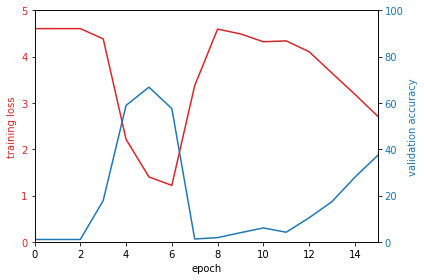

Epoch: 16/20, loss: 2.7128526272423845, validation accuracy: 37.3385%
Epoch: 17/20, loss: 2.3297493820914634, validation accuracy: 45.971%
Epoch: 18/20, loss: 1.9717269712747567, validation accuracy: 53.5075%
Epoch: 19/20, loss: 1.7007108283937995, validation accuracy: 57.514%
Epoch: 20/20, loss: 1.5216648074648893, validation accuracy: 62.2105%
Training ended after 20 ! Best validation accuracy: 66.819%


In [28]:
best_model, losses, accs = train_model(model, optimizer, loss_function, train_loader, val_loader, n_epochs)

In [0]:
print(f"Test accuracy: {evaluate_model(model, test_loader)}%")

In [0]:
model_path = 'lstm_quickdraw.model'
torch.save(best_model, model_path)

print(f"Model saved at: {model_path}")

In [0]:
from google.colab import files
files.download(model_path) 